In [5]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

 12 8863k   12 1133k    0     0   785k      0  0:00:11  0:00:01  0:00:10  785k
100 8863k  100 8863k    0     0  3990k      0  0:00:02  0:00:02 --:--:-- 9935k


In [6]:
!unzip -qq captcha_images_v2.zip


"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [7]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
import keras
from keras import layers

In [8]:
# Указываем путь к директории с данными
data_dir = Path("./captcha_images_v2/")

# Получаем список всех изображений в директории
images = sorted(list(map(str, list(data_dir.glob("*.png")))))

# Извлекаем метки из названий файлов
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

# Получаем уникальные символы, которые встречаются в метках
characters = set(char for label in labels for char in label)

# Сортируем уникальные символы в алфавитном порядке
characters = sorted(list(characters))

# Выводим информацию о данных
print("Количество изображений: ", len(images))
print("Количество меток: ", len(labels))
print("Количество уникальных символов: ", len(characters))
print("Используемые символы: ", characters)

# Размер пакета для обучения и валидации
batch_size = 16

# Желаемые размеры изображения
img_width = 200
img_height = 50

# Фактор уменьшения размера изображения после свертки.
# Используем два блока свертки с пулингом, каждый уменьшает размер в 2 раза,
# поэтому общий фактор уменьшения будет 4.
downsample_factor = 4

# Максимальная длина любой капчи в наборе данных
max_length = max([len(label) for label in labels])

Количество изображений:  1040
Количество меток:  1040
Количество уникальных символов:  19
Используемые символы:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [9]:
# Отображение символов в целые числа
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Отображение целых чисел обратно в оригинальные символы
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def split_data(images, labels, train_size=0.8, shuffle=True):
    # 1. Получение общего размера набора данных
    size = len(images)
    # 2. Создание массива индексов и их перемешивание, если нужно
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Определение размера обучающей выборки
    train_samples = int(size * train_size)
    # 4. Разделение данных на обучающий и валидационный наборы
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Разделение данных на обучающий и валидационный наборы
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    # 1. Чтение изображения
    img = tf.io.read_file(img_path)
    # 2. Декодирование и преобразование в оттенки серого
    img = tf.io.decode_png(img, channels=1)
    # 3. Преобразование в формат float32 в диапазоне [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Изменение размера до желаемого размера
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Транспонирование изображения, потому что мы хотим, чтобы размер времени
    # соответствовал ширине изображения.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Отображение символов в числа
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Возврат словаря, так как наша модель ожидает два входа
    return {"image": img, "label": label}

In [10]:
# Создание обучающего датасета из массивов данных
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Применение функции encode_single_sample к каждому элементу датасета параллельно
# с использованием максимально возможного количества ядер процессора (tf.data.AUTOTUNE)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)  # Группировка данных в пакеты заданного размера
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Предварительная загрузка данных для улучшения производительности
)

# Создание валидационного датасета из массивов данных
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

# Применение функции encode_single_sample к каждому элементу датасета параллельно
# с использованием максимально возможного количества ядер процессора (tf.data.AUTOTUNE)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)  # Группировка данных в пакеты заданного размера
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Предварительная загрузка данных для улучшения производительности
)

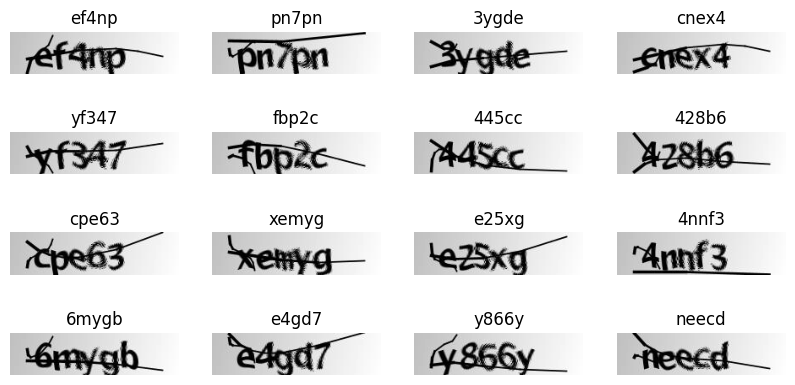

In [11]:
# Создание сетки изображений для визуализации образцов из обучающего датасета
_, ax = plt.subplots(4, 4, figsize=(10, 5))

# Взятие одного батча из обучающего датасета
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        # Преобразование изображения к формату uint8 для отображения
        img = (images[i] * 255).numpy().astype("uint8")
        # Декодирование числовой метки в строку
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        # Отображение изображения в i-том элементе сетки
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        # Установка заголовка с текстом метки
        ax[i // 4, i % 4].set_title(label)
        # Отключение координатных осей
        ax[i // 4, i % 4].axis("off")

# Отображение сетки изображений
plt.show()

In [12]:
# Определение функции стоимости Connectionist Temporal Classification (CTC) для батча
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    # Приведение размерности label_length и input_length
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    
    # Преобразование меток в разреженный формат
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    # Преобразование логарифмов предсказаний и вычисление CTC loss
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

# Преобразование меток в разреженный формат
def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )

# Класс CTCLayer для интеграции CTC loss в модель
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Вычисление значения функции стоимости и добавление ее в слой с помощью `self.add_loss()`
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Во время тестирования возвращаем предсказания
        return y_pred

# Функция для построения модели OCR
def build_model():
    # Входные данные модели
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Первый блок свертки
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Второй блок свертки
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Использованы два слоя максимального пулинга с размером и шагом 2.
    # Следовательно, уменьшение размера признаковых карт в 4 раза.
    # Количество фильтров в последнем слое - 64. Перед передачей
    # выхода в часть модели с рекуррентными слоями изменяем форму
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # Рекуррентные слои (Bi-LSTM)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Выходной слой
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Добавление слоя CTC для вычисления CTC loss на каждом шаге
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Определение модели
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    
    # Оптимизатор
    opt = keras.optimizers.Adam()
    
    # Компиляция модели и возврат
    model.compile(optimizer=opt)
    return model

# Получение модели
model = build_model()
model.summary()



Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                     

In [13]:
# TODO restore epoch count.
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
52/52 [==============================] - 8s 71ms/step - loss: 27.2983 - val_loss: 16.4223
Epoch 2/100
52/52 [==============================] - 2s 46ms/step - loss: 16.4078 - val_loss: 16.3719
Epoch 3/100
52/52 [==============================] - 2s 46ms/step - loss: 16.3732 - val_loss: 16.3624
Epoch 4/100
52/52 [==============================] - 2s 46ms/step - loss: 16.3620 - val_loss: 16.3590
Epoch 5/100
52/52 [==============================] - 2s 47ms/step - loss: 16.3572 - val_loss: 16.3581
Epoch 6/100
52/52 [==============================] - 2s 46ms/step - loss: 16.3508 - val_loss: 16.3546
Epoch 7/100
52/52 [==============================] - 3s 48ms/step - loss: 16.3397 - val_loss: 16.3671
Epoch 8/100
52/52 [==============================] - 2s 46ms/step - loss: 16.3327 - val_loss: 16.3679
Epoch 9/100
52/52 [==============================] - 2s 45ms/step - loss: 16.3141 - val_loss: 16.3942
Epoch 10/100
52/52 [==============================] - 2s 45ms/step - loss: 16.2913

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

1/1 [==============================] - 1s 810ms/step


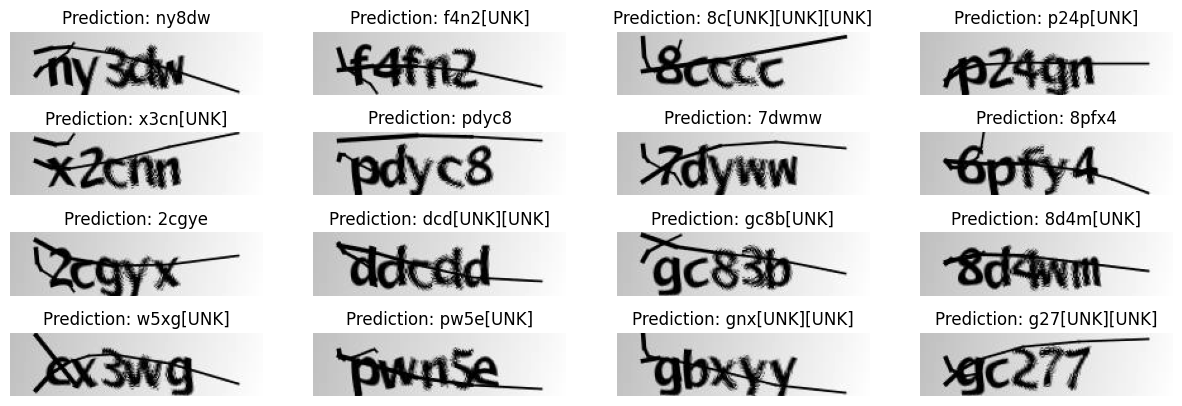

In [14]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = tf.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())
    input_length = tf.cast(input_length, tf.int32)

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()


In [15]:
png = encode_single_sample("x72cf.png", "x72cf")
# print(png["image"])
preds = prediction_model.predict(np.array([png["image"]]))
pred_texts = decode_batch_predictions(preds)
print(pred_texts)

1/1 [==============================] - 0s 20ms/step
['4[UNK][UNK][UNK][UNK]']
